# 14. SAC Algo

## 14.1. Intro

## 14.2. Maximum Entropy RL 最大熵强化学习

$H(X) = \mathbb{E}_{x \sim p}[- \log p(x)]$

maximum entropy rl: adding entropy term

$\pi^* = \argmax_\pi\mathbb{E}_\pi\left[\sigma_t r(s_t, a_t) + \alpha H(\pi(\cdot | s_t))\right]$

## 14.3. Soft Policy Iteration

$Q(s_t, a_t) = r(s_t, a_t) + \gamma \mathbb{E}{s_{t+1}}[V(s_{t+1})]$

$V(s_t) = \mathbb{E}_{a_t \sim \pi}[Q(s_t, a_t) - \alpha \log \pi (a_t | s_t)] = \mathbb{E}_{a_t \sim \pi}[Q(s_t, a_t)] + H(\pi(\cdot | s_t))$

$\pi_{new} = \argmin_{\pi'} D_{KL}(\pi'(\cdot | s), \frac{e^{\frac1\alpha Q^{\pi_{old}}(s, \cdot)}}{Z^{\pi_{old}}(s, \cdot)})$

## 14.4. SAC

$$
\begin{aligned}
L_Q(\omega) &= \mathbb{E}_{(s_t, a_t, r_t, s_{t + 1}) \sim R}\left[\frac12(Q_\omega(s_t, a_t) - (r_t + \gamma V_{\omega^-}(s_{t + 1})))^2\right] \\
&= \mathbb{E}_{(s_t, a_t, r_t, s_{t + 1}) \sim R, a_{t + 1} \sim \pi_\theta(\cdot | s_{t + 1})}\left[\frac12(Q_\omega(s_t, a_t) - (r_t + \gamma (\min_{j=1,2}Q_{\omega_j^-}(s_{t + 1}, a_{t + 1}) - \alpha \log \pi(a_{t + 1} | s_{t + 1}))))^2\right]
\end{aligned}
$$

化简, 得到

$L_\pi(\theta) = \mathbb{E}_{s_t \sim R, a_t \sim \pi_\theta}[\alpha\log(\pi_\theta(a_t | s_t)) - Q_\omega(s_t, a_t)]$

利用重参数化技巧(reparameterization, trick)

$$
L_\pi(\theta) = \mathbb{E}_{s_t \sim R, \epsilon_t \sim \mathcal{N}}\left[\alpha\log(\pi_\theta(f_\theta(\epsilon_t; s_t)| s_t)) - \min_{j = 1,2}Q_{\omega_j}(s_t, f_\theta(\epsilon_t; s_t))\right]
$$

自动调整熵正则项

$$
\max_\pi\mathbb{E}_\pi\left[\sum_t r(s_t, a_t)\right], \text{s.t.} \mathbb{E}_{(s_t, a_t) \sim \rho_\pi}\left[-\log(\pi_t(a_t|s_t))\right] \geq \mathcal{H}_0
$$

$$
L(\alpha) = \mathbb{E}_{s_t \sim R, a_t \sim \pi(\cdot | s_t)}[-\alpha \log \pi(a_t | s_t) - \alpha \mathcal{H}_0]
$$

伪代码 SAC：
1. 随机初始化策略网络参数$\omega_1, \omega_2, \theta$ 分别初始化Critic网络$Q_{\omega_1}(s, a), Q_{\omega_2}(s, a)$和Actor网络$\pi_\theta(s)$
2. 复制相同的参数$\omega_1^- \leftarrow \omega_1, \omega_2^- \leftarrow \omega_2$, 分别初始化目标网络$Q_{\omega_1^-}, Q_{\omega_2^-}$
3. 初始化经验回放池$R$
4. **for**  $e = 1 \rightarrow E$ **do**:
   1. 获取环境初始状态$s_1$
   2. **for** $t = 1 \rightarrow T$ **do**
      1. 根据当前策略选择动作$a_t = \pi_\theta(s_t)$
      2. 指定动作$a_t$, 获得奖励$r_t$, 环境步进为$s_{t + 1}$
      3. $(s_t, a_t, r_t, s_{t+1})$存放池$R$
      4. **for** $k = 1 \rightarrow K$ **do**
         1. 从$R$中采样$N$个元组 $\left\{(s_i, a_i, r_i, s_{i + 1})\right\}_{i=1,......,N}$
         2. 对每个元组，目标网络计算$y_i = r_i + \gamma \min_{j =1,2} Q_{\omega_j^-}(s_{i+1}, a_{i+1}) - \alpha\log\pi_\theta(a_{i+1}|s_{i+1})$, $a_{i+1}\sim \pi_\theta(\cdot|s_{i+1})$ 
         3. 对两个Critic网络如下更新$j = 1, 2$, 最小化损失函数 $L = \frac1N\sum_{i=1}^N(y_i - Q_{\omega_j}(s_i, a_i))^2$
         4. 重参数化技巧采样动作$\tilde{a}_i$, 用以下损失函数更新当前Actor网络: $L_\pi(\theta) = \frac1N\sum_{i=1}^N(\alpha\log\pi_\theta(\tilde{a}_i|s_i) -\min_{j=1,2}Q_{\omega_j}(s_i, \tilde{a_i}))^2$
         5. 更新熵正则项系数$\alpha$
         6. 更新目标网络：$\omega_1^- \leftarrow \tau\omega_1 + (1 - \tau)\omega_1^-, \omega_2^- \leftarrow \tau \omega_2 + (1 - \tau)\omega_2^-$
      5. **end for**
   3. **end for** 
5. **end for**

## 14.5. SAC code

In [32]:
import random
import gym
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import rl_utils

In [33]:
class PolicyNetContinuous(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
    super(PolicyNetContinuous, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
    self.action_bound = action_bound
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    mu = self.fc_mu(x)
    std = F.softplus(self.fc_std(x))
    dist = Normal(mu, std)
    normal_sample = dist.rsample() # rsample()是重参数化采样
    log_prob = dist.log_prob(normal_sample)
    action = torch.tanh(normal_sample)
    # 计算tanh_normal分布的对数概率密度
    log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
    action = action * self.action_bound
    return action, log_prob
  
class QValueNetContinuous(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(QValueNetContinuous, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc_out = torch.nn.Linear(hidden_dim, 1)
  
  def forward(self, x, a):
    cat = torch.cat([x, a], dim=1)
    x = F.relu(self.fc1(cat))
    x = F.relu(self.fc2(x))
    return self.fc_out(x)

In [34]:
class SACContinuous:
  """ 连续动作的SAC算法 """
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
              actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, 
              device):
    self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device) # 策略网络
    self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) #  第一个Q网络
    self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) #  第二个Q网络
    self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) # 第一个目标Q网络
    self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) # 第一个目标Q网络
    
    # 令目标Q网络的初始参数和Q网络一样
    self.target_critic_1.load_state_dict(self.critic_1.state_dict())
    self.target_critic_2.load_state_dict(self.critic_2.state_dict())
    
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    
    self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
    self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
    
    # 使用alpha的log值,可以使训练结果比较稳定
    self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
    self.log_alpha.requires_grad = True # 可以对alpha求梯度
    self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
    self.target_entropy = target_entropy # 目标熵的大小
    self.gamma = gamma
    self.tau = tau
    self.device = device
    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    action = self.actor(state)[0]
    return [action.item()]
  
  def calc_target(self, rewards, next_states, dones): #  计算目标Q值
    next_actions, log_prob = self.actor(next_states)
    entropy = -log_prob
    q1_value = self.target_critic_1(next_states, next_actions)
    q2_value = self.target_critic_2(next_states, next_actions)
    next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
    td_target = rewards + self.gamma * next_value * (1 - dones)
    return td_target
  
  def soft_update(self, net, target_net):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau) 
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
    rewards = (rewards + 8.0) /8.0
    
    # 更新两个Q网络
    td_target = self.calc_target(rewards, next_states, dones)
    critic_1_loss = torch.mean(
      F.mse_loss(self.critic_1(states, actions), td_target.detach())
    )
    critic_2_loss = torch.mean(
      F.mse_loss(self.critic_2(states, actions), td_target.detach())
    )
    self.critic_1_optimizer.zero_grad()
    critic_1_loss.backward()
    self.critic_1_optimizer.step()
    self.critic_2_optimizer.zero_grad()
    critic_2_loss.backward()
    self.critic_2_optimizer.step()
    
    # 更新策略网络
    new_actions, log_prob = self.actor(states)
    entropy = -log_prob
    q1_value = self.critic_1(states, new_actions)
    q2_value = self.critic_2(states, new_actions)
    actor_loss = torch.mean(-self.log_alpha.exp() * entropy 
                            - torch.min(q1_value, q2_value))
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
    
    # 更新alpha值
    alpha_loss = torch.mean(
      (entropy - self.target_entropy).detach() * self.log_alpha.exp()
    )
    self.log_alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.log_alpha_optimizer.step()
    
    self.soft_update(self.critic_1, self.target_critic_1)
    self.soft_update(self.critic_2, self.target_critic_2)

In [35]:
env_name= "Pendulum-v1"
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
action_bound = env.action_space.high[0]
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005 # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau, 
                      gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

Iteration 9: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it, episode=100, return=-192.690]


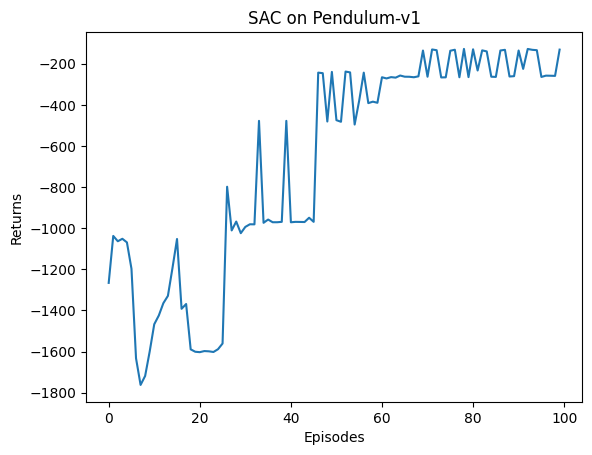

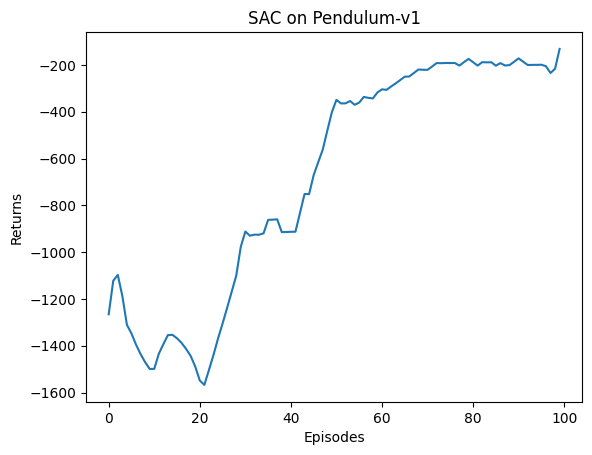

In [36]:
episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episode_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

In [40]:
class PolicyNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    return F.softmax(self.fc2(x), dim=1)
  
class QValueNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(QValueNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    return (self.fc2(x))

In [41]:
class SAC:
  """ 连续动作的SAC算法 """
  def __init__(self, state_dim, hidden_dim, action_dim,
              actor_lr, critic_lr, alpha_lr, target_entropy, 
              tau, gamma, device):
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device) # 策略网络
    self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device) #  第一个Q网络
    self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device) #  第二个Q网络
    self.target_critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device) # 第一个目标Q网络
    self.target_critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device) # 第一个目标Q网络
    
    # 令目标Q网络的初始参数和Q网络一样
    self.target_critic_1.load_state_dict(self.critic_1.state_dict())
    self.target_critic_2.load_state_dict(self.critic_2.state_dict())
    
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    
    self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
    self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
    
    # 使用alpha的log值,可以使训练结果比较稳定
    self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
    self.log_alpha.requires_grad = True # 可以对alpha求梯度
    self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
    
    self.target_entropy = target_entropy # 目标熵的大小
    self.gamma = gamma
    self.tau = tau
    self.device = device
    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.actor(state)
    action_dist = torch.distributions.Categorical(probs)
    action = action_dist.sample()
    return action.item()
  
  # 计算目标Q值,直接用策略网络的输出概率进行期望计算
  def calc_target(self, rewards, next_states, dones): #  计算目标Q值
    next_probs = self.actor(next_states)
    next_log_probs = torch.log(next_probs + 1e-8)
    entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
    q1_value = self.target_critic_1(next_states)
    q2_value = self.target_critic_2(next_states)
    min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value),
                          dim=1,
                          keepdim=True)
    next_value = min_qvalue + self.log_alpha.exp() * entropy
    td_target = rewards + self.gamma * next_value * (1 - dones)
    return td_target
  
  def soft_update(self, net, target_net):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau) 
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions'],).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
    
    # 更新两个Q网络
    td_target = self.calc_target(rewards, next_states, dones)
    critic_1_q_values = self.critic_1(states).gather(1, actions)
    critic_1_loss = torch.mean(
      F.mse_loss(critic_1_q_values, td_target.detach())
    )
    critic_2_q_values = self.critic_2(states).gather(1, actions)
    critic_2_loss = torch.mean(
      F.mse_loss(critic_2_q_values, td_target.detach())
    )
    self.critic_1_optimizer.zero_grad()
    critic_1_loss.backward()
    self.critic_1_optimizer.step()
    self.critic_2_optimizer.zero_grad()
    critic_2_loss.backward()
    self.critic_2_optimizer.step()
    
    # 更新策略网络
    probs = self.actor(states)
    log_probs = torch.log(probs + 1e-8)
    # 直接根据概率计算熵
    entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)
    
    q1_value = self.critic_1(states)
    q2_value = self.critic_2(states)
    min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value),
                          dim=1,
                          keepdim=True)
    
    actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
    
    # 更新alpha值
    alpha_loss = torch.mean(
      (entropy - self.target_entropy).detach() * self.log_alpha.exp()
    )
    self.log_alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.log_alpha_optimizer.step()
    
    self.soft_update(self.critic_1, self.target_critic_1)
    self.soft_update(self.critic_2, self.target_critic_2)

In [42]:
actor_lr = 1e-3
critic_lr = 1e-2
alpha_lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
tau = 0.005 # 软更新参数
buffer_size = 100000
minimal_size = 500
batch_size = 64
target_entropy = -1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name= "CartPole-v1"
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n 
agent = SAC(state_dim, hidden_dim, action_dim,
            actor_lr, critic_lr, alpha_lr, target_entropy, tau, 
            gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

Iteration 9: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it, episode=200, return=183.100]


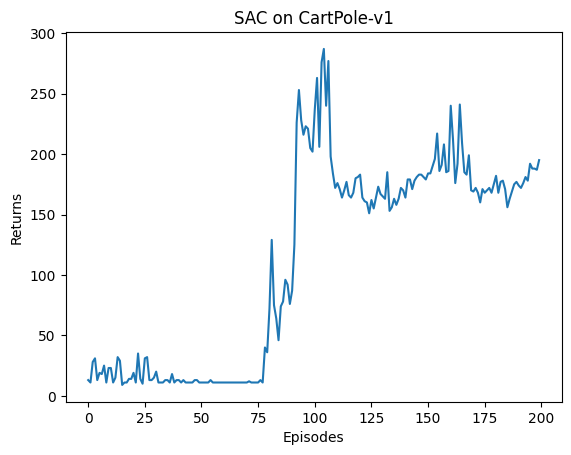

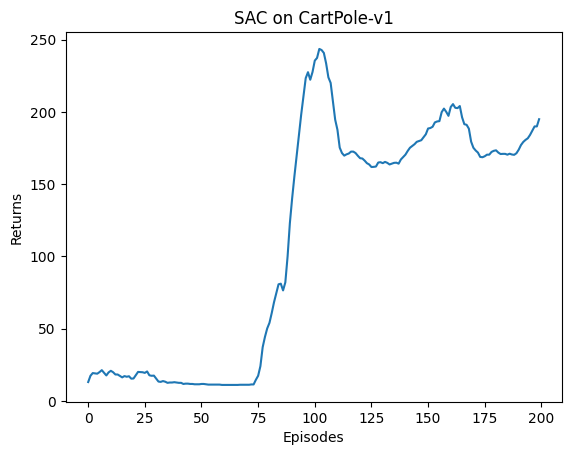

In [43]:
episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episode_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()